# Хакатон Ozon







##Загрузка данных

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from google.colab import files
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import shutil
import torchvision.models as models
from collections import Counter

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# разные режимы загрузки датасета
data_modes = ['train', 'val', 'test']

class SmokingDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file).convert("RGB")
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((128, 128))
        return np.array(image)

In [3]:
os.system('git clone https://github.com/VsevolodMisyurin/train_lite_augmented.git')

train_dir = Path('train_lite_augmented')
train_val_files = list(train_dir.rglob('*.jpg'))
train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_dataset = SmokingDataset(train_files, mode='train')
val_dataset = SmokingDataset(val_files, mode='val')

Читаем данные

Разделяем на выборки

Определим функции для отображения картинок и выведем 9 случайных из трейна

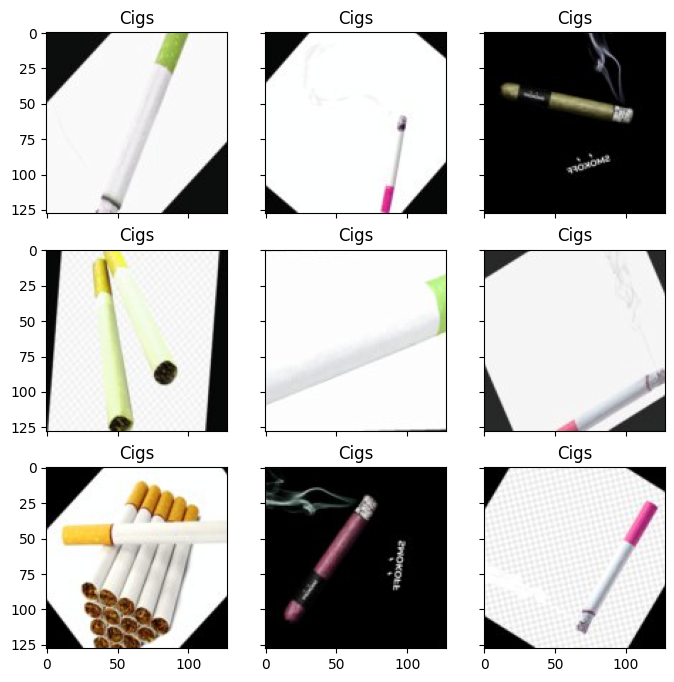

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    plt_ax.set_title(title)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 871))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

##Знакомство с данными, дисбаланс классов

In [5]:
class_names = train_dataset.label_encoder.classes_
print(len(class_names))
print(class_names)

5
['cigs' 'other' 'pipes' 'roll_cigs' 'smoking']


Посмотрим на количество объектов в каждом классе тренировочной выборки

In [6]:
len(train_files)

11167

In [7]:
train_labels = [path.parent.name for path in train_files]
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс pipes, количество 2234, доля 20.01%
Класс cigs, количество 2233, доля 20.00%
Класс other, количество 2233, доля 20.00%
Класс smoking, количество 2234, доля 20.01%
Класс roll_cigs, количество 2233, доля 20.00%


Видим явный дисбаланс классов, для борьбы с ним применим разнообразную аугментацию

###Борьба с дисбалансом: аугментация миноритарных классов

Подсчитаем среднее число объектов в классе для того, чтобы провести черту между миноритарными и мажоритарными классами

In [8]:
"""
# Определим трансформации для аугментации
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0))
])

# Определим папку с изображениями и читаем пути к ним
train_files = list(Path("/content/train_lite").rglob("*.jpg"))
train_labels = [path.parent.name for path in train_files]

# Получим метки классов и количество изображений в каждом классе
counter = Counter(train_labels)
max_count = 2610

# Создадим папку для увеличенных данных
augmented_data_dir = Path("/content/augmented_data")
augmented_data_dir.mkdir(exist_ok=True)

for label, count in counter.items():
    label_dir = augmented_data_dir / label
    label_dir.mkdir(exist_ok=True)

    # Получаем все изображения текущего класса
    class_images = [path for path in train_files if path.parent.name == label]
    num_augmentations = max_count - count

    if num_augmentations > 0:
        # Вычисляем, сколько копий каждого изображения нужно сделать
        augment_per_image = int(np.ceil(num_augmentations / count))

        for img_path in class_images:
            # Копируем оригинальное изображение
            shutil.copy(img_path, label_dir / img_path.name)

            # Применяем аугментации
            img = Image.open(img_path)
            for i in range(augment_per_image):
                augmented_img = transform(img)
                augmented_img.save(label_dir / f"{img_path.stem}_aug_{i}.jpg")

total_augmented = 0
# Если нужно более точно распределить, используйте np.linspace
for label, count in counter.items():
    class_images = [path for path in train_files if path.parent.name == label]
    num_augmentations = max_count - count

    if num_augmentations > 0:
        indices = np.linspace(0, count - 1, num=num_augmentations, dtype=int)
        for idx in indices:
            img_path = class_images[idx]
            img = Image.open(img_path)
            augmented_img = transform(img)
            augmented_img.save(label_dir / f"{img_path.stem}_aug_{idx}.jpg")

print(f"Total augmented images created: {total_augmented}")
"""

'\n# Определим трансформации для аугментации\ntransform = transforms.Compose([\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomRotation(10),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),\n    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0))\n])\n\n# Определим папку с изображениями и читаем пути к ним\ntrain_files = list(Path("/content/train_lite").rglob("*.jpg"))\ntrain_labels = [path.parent.name for path in train_files]\n\n# Получим метки классов и количество изображений в каждом классе\ncounter = Counter(train_labels)\nmax_count = 2610\n\n# Создадим папку для увеличенных данных\naugmented_data_dir = Path("/content/augmented_data")\naugmented_data_dir.mkdir(exist_ok=True)\n\nfor label, count in counter.items():\n    label_dir = augmented_data_dir / label\n    label_dir.mkdir(exist_ok=True)\n\n    # Получаем все изображения текущего класса\n    class_images = [path for path in train_files if path.parent.name == lab

In [9]:
"""
# Обновим список файлов и метки
train_files = list(augmented_data_dir.glob('**/*.jpg'))
train_labels = [path.parent.name for path in train_files]
"""

"\n# Обновим список файлов и метки\ntrain_files = list(augmented_data_dir.glob('**/*.jpg'))\ntrain_labels = [path.parent.name for path in train_files]\n"

In [10]:
# folder_path = '/content/augmented_data'
# shutil.make_archive('/content/folder_archive', 'zip', folder_path)
# files.download('/content/folder_archive.zip')

In [8]:
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс pipes, количество 2234, доля 20.01%
Класс cigs, количество 2233, доля 20.00%
Класс other, количество 2233, доля 20.00%
Класс smoking, количество 2234, доля 20.01%
Класс roll_cigs, количество 2233, доля 20.00%


In [12]:
train_dataset = SmokingDataset(train_files, mode='train')
val_dataset = SmokingDataset(val_files, mode='val')

In [9]:
len(train_dataset), len(val_dataset)

(11167, 3723)

###Разделение на батчи

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False)
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ba4e61c7af0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ba4e61c55a0>)

Проверка батча

In [11]:
img, label = next(iter(train_loader))
print(f"Размерность изображения: {img.shape} -> [размер батча, цветовые каналы, высота, ширина]")

Размерность изображения: torch.Size([32, 3, 128, 128]) -> [размер батча, цветовые каналы, высота, ширина]


##Transfer learning

###Создание функции обучения с замером времени и функции оценки

In [12]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Эпоха {epoch+1}')
        val_loss, val_report = evaluate(model, val_loader, loss_fn)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time} секунд")
    return model, train_time

def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    all_preds = []
    all_labels = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    mean_loss = total_loss / len(data_loader)
    report = classification_report(all_labels, all_preds, output_dict=True)

    print(f"Функция потерь (кросс-энтропия) на данных: {mean_loss}")
    print(f"Precision: {report['weighted avg']['precision']}")
    print(f"Recall: {report['weighted avg']['recall']}")
    print(f"F1-мера: {report['weighted avg']['f1-score']}")

    return mean_loss, report

Функция вывода матрицы ошибок

In [13]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                      index=class_names,
                      columns=class_names)
    plt.figure(figsize=(20, 16))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    plt.show()

###Загрузка предобученных моделей, замена выходного слоя

In [14]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.1 MB/s eta 0:00:00


In [20]:
"""
import timm
import torch.nn as nn

# Загрузка модели ConvNeXt V2 Tiny через timm
model_ConvNeXtV2 = timm.create_model('convnextv2_tiny', pretrained=True)

# Адаптация последнего слоя под 5 классов
model_ConvNeXtV2.head.fc = nn.Linear(model_ConvNeXtV2.head.fc.in_features, 5)

# Сохранение модели
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Например, сохранение модели
torch.save(model_ConvNeXtV2.state_dict(), MODEL_PATH / "convnext_v2_tiny_5_classes.pth")
"""

'\nimport timm\nimport torch.nn as nn\n\n# Загрузка модели ConvNeXt V2 Tiny через timm\nmodel_ConvNeXtV2 = timm.create_model(\'convnextv2_tiny\', pretrained=True)\n\n# Адаптация последнего слоя под 5 классов\nmodel_ConvNeXtV2.head.fc = nn.Linear(model_ConvNeXtV2.head.fc.in_features, 5)\n\n# Сохранение модели\nMODEL_PATH = Path("models")\nMODEL_PATH.mkdir(parents=True, exist_ok=True)\n\n# Например, сохранение модели\ntorch.save(model_ConvNeXtV2.state_dict(), MODEL_PATH / "convnext_v2_tiny_5_classes.pth")\n'

###Обучение предобученной модели на наших классах

In [15]:
!ls /content/  # Перетаскиваю модель и просто проверяю её наличие

model_ConvNeXtV2_lite_epochs5.pth  sample_data	train_lite_augmented


In [16]:
import timm
model_path = "/content/model_ConvNeXtV2_lite_epochs5.pth"

# Создайте модель ConvNeXt V2 Tiny с той же архитектурой
model_ConvNeXtV2 = timm.create_model('convnextv2_tiny', pretrained=False)  # pretrained=False, чтобы не перезаписывать ваши веса
model_ConvNeXtV2.head.fc = nn.Linear(model_ConvNeXtV2.head.fc.in_features, 5)  # Адаптация последнего слоя под 5 классов

# Загрузите состояние модели из файла
model_ConvNeXtV2.load_state_dict(torch.load(model_path))

# Создайте директорию для сохранения моделей, если нужно
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

<ipython-input-16-cad484572034>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ConvNeXtV2.load_state_dict(torch.load(model_path))


In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
# Пример проверки размерностей
for images, labels in train_loader:
    print(images.size())  # Ожидается (batch_size, 3, height, width)
    print(labels.size())  # Ожидается (batch_size, )
    break


torch.Size([32, 3, 128, 128])
torch.Size([32])


####Модель model_ConvNeXtV2

In [19]:
optimizer = torch.optim.Adam(model_ConvNeXtV2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model_ConvNeXtV2, train_time = train(model_ConvNeXtV2, train_loader, val_loader, loss_fn, optimizer, 10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных: 0.21587856341865805
Precision: 0.9200840873357311
Recall: 0.9199570239054526
F1-мера: 0.9199273042046336
Эпоха 2
Функция потерь (кросс-энтропия) на данных: 0.2206303607672453
Precision: 0.9244641865731286
Recall: 0.911361804995971
F1-мера: 0.9121226710125647
Эпоха 3
Функция потерь (кросс-энтропия) на данных: 0.13720223172485074
Precision: 0.9519654908223509
Recall: 0.9505774912704807
F1-мера: 0.9504560036206149
Эпоха 4
Функция потерь (кросс-энтропия) на данных: 0.12842538268862563
Precision: 0.9529040576477306
Recall: 0.9524576954069299
F1-мера: 0.9522525778098228
Эпоха 5
Функция потерь (кросс-энтропия) на данных: 0.18429568925281414
Precision: 0.9431543927888789
Recall: 0.9417136717700779
F1-мера: 0.9421629768015148
Эпоха 6
Функция потерь (кросс-энтропия) на данных: 0.10482299264083103
Precision: 0.9658373070684356
Recall: 0.9656191243620736
F1-мера: 0.9655466797577559
Эпоха 7
Функция потерь (кросс-энтропия) на данных: 0.1077778133930

In [20]:
COVNEXTV2 = "/content/model_ConvNeXtV2_lite_epochs15.pth"
torch.save(obj=model_ConvNeXtV2.state_dict(),
           f=COVNEXTV2)
files.download(COVNEXTV2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Матрица для model_ConvNeXtV2

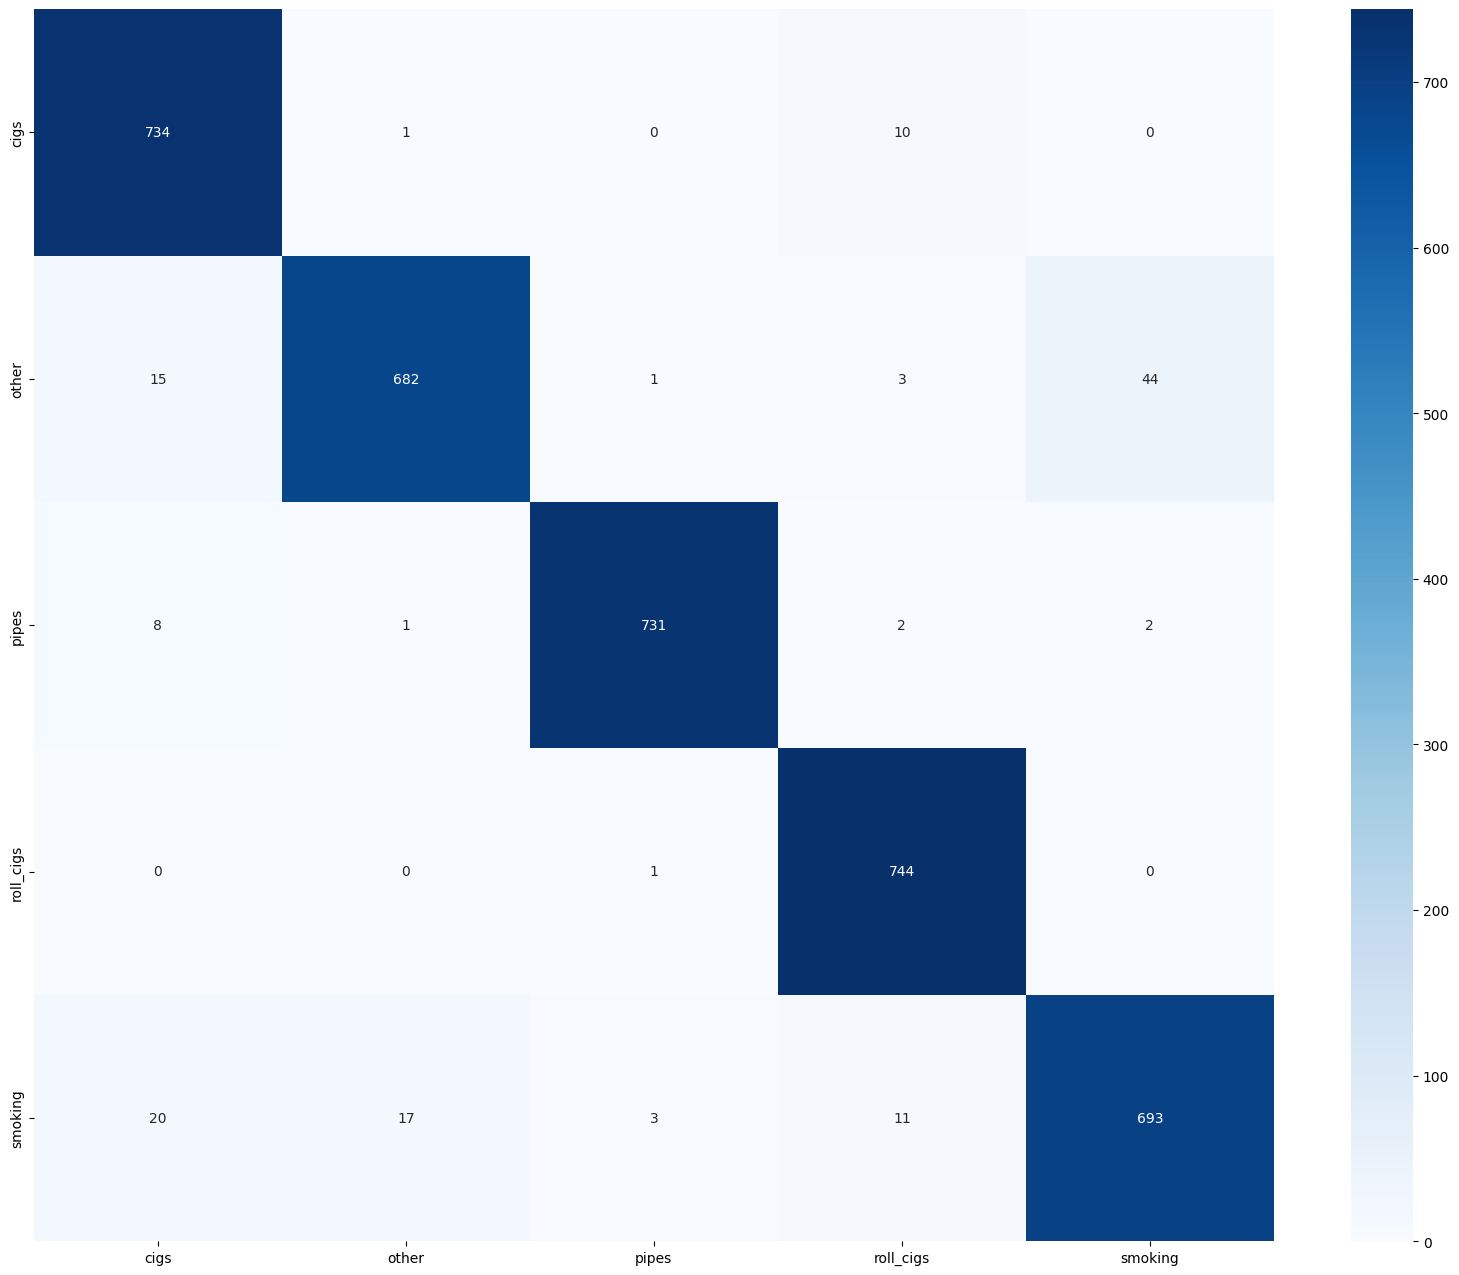

In [21]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ConvNeXtV2(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

In [22]:
model = model_ConvNeXtV2

In [23]:
"""
def visualize_incorrect_predictions(incorrect_preds, class_names, num_images=10):

    # Выбираем нужное количество изображений
    incorrect_preds = incorrect_preds[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for (img, pred, label), ax in zip(incorrect_preds, axes):
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Денормализация
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# После обучения модели
model, train_time = train(model, train_loader, val_loader, loss_fn, optimizer, epochs = 10)

# Получаем ошибочные предсказания
incorrect_preds = find_incorrect_predictions(model, val_loader)

# Визуализируем ошибочные предсказания
visualize_incorrect_predictions(incorrect_preds, class_names, num_images=10)
"""

Эпоха 1
Функция потерь (кросс-энтропия) на данных: 0.14133219298460023
Precision: 0.9632279068720379
Recall: 0.9626645178619393
F1-мера: 0.9626105684416262
Эпоха 2
Функция потерь (кросс-энтропия) на данных: 0.13695873329959438
Precision: 0.9599122530054861
Recall: 0.9567553048616707
F1-мера: 0.957174014719103


KeyboardInterrupt: 

##Функция прогноза по картинке URL

In [24]:
import requests
from io import BytesIO
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [25]:
def predict_url(url, model):

    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    response = requests.get(url, verify=False)
    image = Image.open(BytesIO(response.content))
    image_transformed = transform(image)
    plt.imshow(image_transformed.permute(1, 2, 0))
    model.eval()
    with torch.inference_mode():
        model_output = model(image_transformed.reshape((1, 3, 224, 224)).to(device))
    class_label = torch.argmax(model_output, dim=1)
    predicted_class_label = class_names[class_label]
    print(predicted_class_label)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

smoking


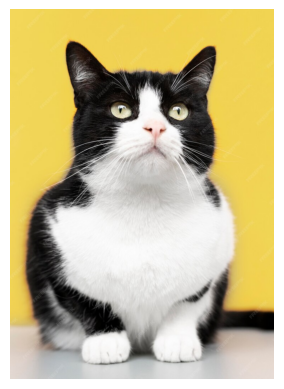

In [28]:
# url = 'https://w.forfun.com/fetch/8c/8ce17ba82fdbfdefe26eaad3754f44ea.jpeg'  # Мистер Бернс
# url = 'https://c.pxhere.com/photos/a4/87/cigarette_cigar_smoking_lung_cancer_unhealthy_smoke_tobacco_smoking_ban-1158198.jpg!d'  # Сигарета
url = 'https://img.freepik.com/free-photo/adorable-black-white-kitty-with-monochrome-wall-her_23-2148955182.jpg?t=st=1724440368~exp=1724443968~hmac=deaf1b9126b6516f2bb9ec7fdaeedc8332ff60b630b92848ff220f4ade7b6c8a&w=740'  # Кот
predict_url(url, model_ConvNeXtV2)

In [34]:
# Функция времени распознавания
import time
from PIL import Image
import requests
from io import BytesIO

def predict_url(url, model):
    # Загружаем изображение из URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # Предварительная обработка изображения (если требуется)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Измените размер в соответствии с вашей моделью
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0)  # Добавляем размер батча

    # Перемещаем изображение на устройство модели (CPU/GPU)
    img = img.to(device)
    model = model.to(device)

    # Начинаем измерение времени
    start_time = time.time()

    # Выполняем предсказание
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted_class = torch.max(output, 1)

    # Заканчиваем измерение времени
    end_time = time.time()

    # Рассчитываем время выполнения
    prediction_time = end_time - start_time

    # Возвращаем результат
    return predicted_class.item(), prediction_time

# Используем функцию predict_url и выводим результат
# url = 'https://img.freepik.com/free-photo/adorable-black-white-kitty-with-monochrome-wall-her_23-2148955182.jpg?t=st=1724440368~exp=1724443968~hmac=deaf1b9126b6516f2bb9ec7fdaeedc8332ff60b630b92848ff220f4ade7b6c8a&w=740'  # Кот
# url = 'https://w.forfun.com/fetch/8c/8ce17ba82fdbfdefe26eaad3754f44ea.jpeg'  # Мистер Бернс
url = 'https://c.pxhere.com/photos/a4/87/cigarette_cigar_smoking_lung_cancer_unhealthy_smoke_tobacco_smoking_ban-1158198.jpg!d'  # Сигарета
predicted_class, prediction_time = predict_url(url, model_ConvNeXtV2)

# Выводим результат
print(f"Предсказанный класс: {predicted_class}")
print(f"Время распознавания: {prediction_time:.4f} секунд")


Предсказанный класс: 0
Время распознавания: 0.0106 секунд


##Функция вывода и прогноза 25 картинок из теста

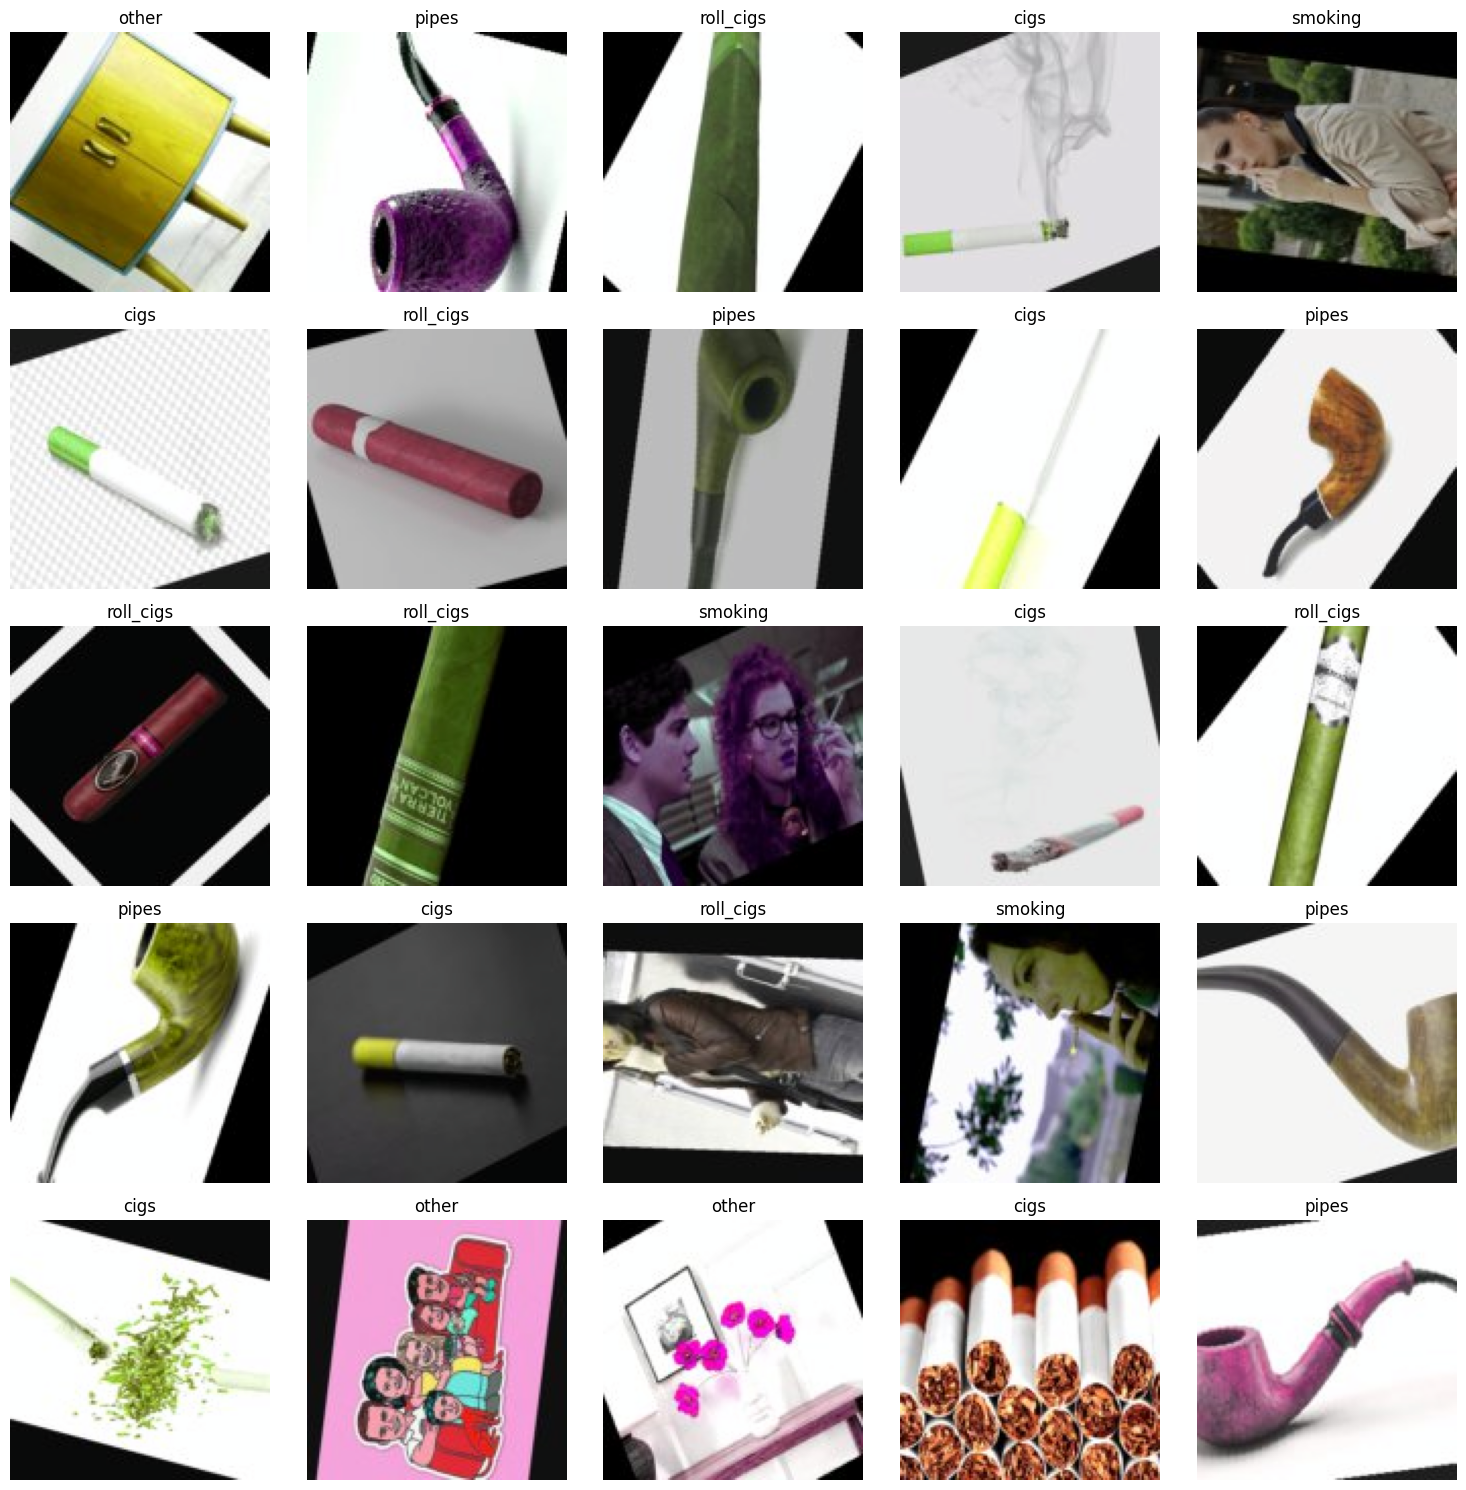

In [39]:
def visualization(dataset, model, class_names, device='cuda'):
    model.to(device)

    dataloader = DataLoader(dataset, batch_size=25, shuffle=True)
    images, labels = next(iter(dataloader))
    images = images.to(device)

    # Перевод модели в режим оценки и для выполнения предсказания
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    for img, pred, ax in zip(images, preds, axes):
        img = img.permute(1, 2, 0).numpy()
        # Денормализация изображения, если изображения нормализованы
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[pred])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualization(val_dataset, model, class_names)